# 1. Imports

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, MinMaxScaler) # Different model scalers
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2. EDA

## 2.1 Data review

In [2]:
df = pd.read_csv('data.csv') # importing the data from provided csv

In [3]:
pd.set_option('Display.max_columns', None) # changing view configuration

#### Observations
* No observations with 'Churn Value' == 0 have a 'Churn Reason', as expected
* 5174 non churners and 5174 null reasons
* Count, Country and State only have 1 value each
* Lat long is just latitude and longitude combined
* Churn label (bool) is the same as Churn value (0 or 1)
* Where Total Charges is empty tenure months is 0, so total charges is actually 0
* When internet service is no, several features are no automatically (multicollinearity)
* Churn reason is useful for recommendations, not useful for predicting who will churn
* When phone service is no 'multiple lines' is 'no phone service'. when phone service is yes 'multiple lines' is either yes or no. (Could drop phone service)

In [4]:
df.columns # viewing the columns/features that could be used to determine their relevance

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Reason'],
      dtype='object')

In [5]:
df.dtypes # checking data types to see which features will need to be changed. Total Charges is an object due to values containing spaces. ' '

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

In [6]:
df['Churn Value'].value_counts() # the two classes that we are predicting aren't balanced. May need to balance or use SMOTE.

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [7]:
df.shape

(7043, 31)

In [8]:
df.describe() # Average churn value is 0.265 showing an inbalance of data again.

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [9]:
df.info() # Only feature with nulls is 'Churn reason' as expected

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [10]:
df.corr(numeric_only = True) # Initial correlation matrix before feature engineering

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zip Code,NaN,1.000000,0.895743,-0.784271,0.001041,-0.004596,0.003346
Latitude,NaN,0.895743,1.000000,-0.876779,-0.001631,-0.019899,-0.003384
Longitude,NaN,-0.784271,-0.876779,1.000000,-0.001678,0.024098,0.004594
Tenure Months,NaN,0.001041,-0.001631,-0.001678,1.000000,0.247900,-0.352229
Monthly Charges,NaN,-0.004596,-0.019899,0.024098,0.247900,1.000000,0.193356
Churn Value,NaN,0.003346,-0.003384,0.004594,-0.352229,0.193356,1.000000


Below is a visualisation of this correlation matrix.

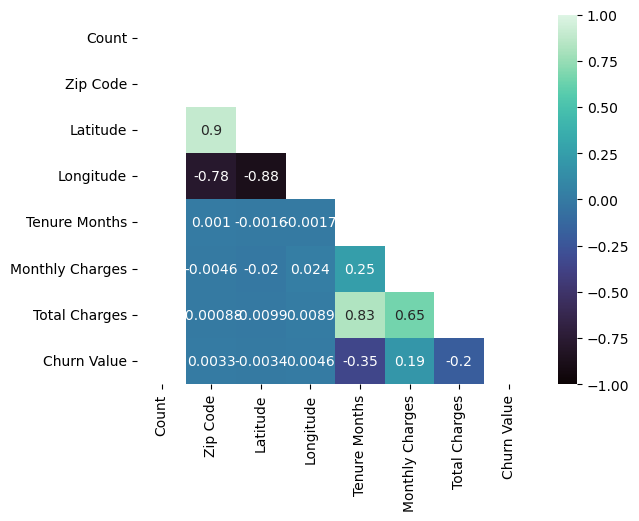

In [87]:
sns.heatmap(df.corr(numeric_only = True), 
            annot = True, 
            vmin = -1, 
            vmax = + 1, 
            mask = np.triu(df.corr(numeric_only=True)),
            cmap = 'mako')
plt.show()

## 2.2 Sanity Checks

By eyeball checking the data we noticed some empty values in the 'Total Charges' column that contained spaces. We investigated why this was and filled those values with 0 since tenure months was 0 in all of these observations.

In [11]:
df['Total Charges'] = df['Total Charges'].str.strip()  # remove spaces from Total charges values

empty_values = (df['Total Charges'] == '').sum() # count the number of empty values
print(f"Empty values in 'Total Charges':{empty_values}")

Empty values in 'Total Charges':11


In [12]:
df.replace(r'^\s*$', np.nan, regex=True).isnull().sum() # counting nulls, which now correctly shows the total charge nulls since we replace them with nothing

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Reason         5174
dtype: int64

In [13]:
df[df['Total Charges']==''] # viewing the observations that have null total charge values. all of these observations have tenure months = 0, so total charges correct value = 0

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
2234,4472-LVYGI,1,United States,California,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,0,NaN
2438,3115-CZMZD,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,0,NaN
2568,5709-LVOEQ,1,United States,California,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,0,NaN
2667,4367-NUYAO,1,United States,California,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,0,NaN
2856,1371-DWPAZ,1,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,0,NaN
4331,7644-OMVMY,1,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,0,NaN
4687,3213-VVOLG,1,United States,California,Sun City,92585,"33.739412, -117.173334",33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,0,NaN
5104,2520-SGTTA,1,United States,California,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,0,NaN
5719,2923-ARZLG,1,United States,California,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,0,NaN
6772,4075-WKNIU,1,United States,California,Bell,90201,"33.970343, -118.171368",33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,0,NaN


In [14]:
df.loc[df['Tenure Months'] == 0, 'Total Charges'] = 0 # correcting the total charge value to equal 0
df['Total Charges'] = df['Total Charges'].astype(float) # changing the data type of total charges to 0

In [15]:
len(df) == len(df.drop_duplicates()) # check for duplicates. dataframes are the same length so there are no duplicate observations

True

In [16]:
df[df['Churn Label'].map({'Yes': 1, 'No': 0}) != df['Churn Value']] # checking that all Churn Label and Churn Value values match within an observation

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason


In [17]:
df[df['Total Charges'] == 0] # checking that the observations that were missing a total charges value are not accurate

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
2234,4472-LVYGI,1,United States,California,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No,0,NaN
2438,3115-CZMZD,1,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No,0,NaN
2568,5709-LVOEQ,1,United States,California,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No,0,NaN
2667,4367-NUYAO,1,United States,California,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No,0,NaN
2856,1371-DWPAZ,1,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No,0,NaN
4331,7644-OMVMY,1,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No,0,NaN
4687,3213-VVOLG,1,United States,California,Sun City,92585,"33.739412, -117.173334",33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No,0,NaN
5104,2520-SGTTA,1,United States,California,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No,0,NaN
5719,2923-ARZLG,1,United States,California,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No,0,NaN
6772,4075-WKNIU,1,United States,California,Bell,90201,"33.970343, -118.171368",33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No,0,NaN


## 2.3 Visualisations

In [18]:
feature_cols = [ # Features that we believe may be useful
    'Latitude',
    'Longitude',
    'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    'Tenure Months',
    'Phone Service',
    'Multiple Lines', 
    'Internet Service', 
    'Online Security',
    'Online Backup', 
    'Device Protection', 
    'Tech Support', 
    'Streaming TV',   
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method',
    'Monthly Charges',
    'Total Charges',
    'Churn Value'
]

# If we label encode 'No internet service' as its own value:
# def visual_engineering(df): # feature engineering to make visualisations easier to read
#     df = df[feature_cols].copy()
#     df['Gender'] = df['Gender'].map({'Female':0, 'Male':1, 0:0, 1:1})
#     df['Senior Citizen'] = df['Senior Citizen'].map({'No':0, 'Yes':1, 0:0, 1:1})
#     df['Partner'] = df['Partner'].map({'No':0, 'Yes':1, 0:0, 1:1})
#     df['Dependents'] = df['Dependents'].map({'No':0, 'Yes':1, 0:0, 1:1})
#     df['Phone Service'] = df['Phone Service'].map({'No':0, 'Yes':1, 0:0, 1:1})
#     df['Multiple Lines'] = df['Multiple Lines'].map({'No':1, 'Yes':2, 'No phone service':0, 0:0, 1:1, 2:2}) # not possible : 0, chosen no : 1, chosen yes : 2 made the most sense
#     df['Internet Service'] = df['Internet Service'].map({'DSL':1, 'Fiber optic':2, 'No':0, 0:0, 1:1, 2:2})
#     df['Online Security'] = df['Online Security'].map({'No':1, 'Yes':2, 'No internet service':0, 0:0, 1:1, 2:2})
#     df['Online Backup'] = df['Online Backup'].map({'No':1, 'Yes':2, 'No internet service':0, 0:0, 1:1, 2:2})
#     df['Device Protection'] = df['Device Protection'].map({'No':1, 'Yes':2, 'No internet service':0, 0:0, 1:1, 2:2})
#     df['Tech Support'] = df['Tech Support'].map({'No':1, 'Yes':2, 'No internet service':0, 0:0, 1:1, 2:2})
#     df['Streaming TV'] = df['Streaming TV'].map({'No':1, 'Yes':2, 'No internet service':0, 0:0, 1:1, 2:2})
#     df['Streaming Movies'] = df['Streaming Movies'].map({'No':1, 'Yes':2, 'No internet service':0, 0:0, 1:1, 2:2})
#     df['Contract'] = df['Contract'].map({'Month-to-month':0, 'Two year':2, 'One year':1, 0:0, 1:1, 2:2}) # longer = larger value
#     df['Paperless Billing'] = df['Paperless Billing'].map({'No':0, 'Yes':1, 0:0, 1:1})
#     df['Payment Method'] = df['Payment Method'].map({'Mailed check':3, 'Electronic check':2, 'Bank transfer (automatic)':1, 'Credit card (automatic)':0, 0:0, 1:1, 2:2, 3:3}) # more effort = larger value
        
#     return df

# If we label encode 'No internet service' as if it was no:
def visual_engineering(df): # feature engineering to make visualisations easier to read
    df = df[feature_cols].copy()
    df['Gender'] = df['Gender'].map({'Female':0, 'Male':1, 0:0, 1:1})
    df['Senior Citizen'] = df['Senior Citizen'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Partner'] = df['Partner'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Dependents'] = df['Dependents'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Phone Service'] = df['Phone Service'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Multiple Lines'] = df['Multiple Lines'].map({'No':0, 'Yes':1, 'No phone service':0, 0:0, 1:1}) # not possible : 0, chosen no : 1, chosen yes : 2 made the most sense
    df['Internet Service'] = df['Internet Service'].map({'DSL':1, 'Fiber optic':2, 'No':0, 0:0, 1:1, 2:2})
    df['Online Security'] = df['Online Security'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
    df['Online Backup'] = df['Online Backup'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
    df['Device Protection'] = df['Device Protection'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
    df['Tech Support'] = df['Tech Support'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
    df['Streaming TV'] = df['Streaming TV'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
    df['Streaming Movies'] = df['Streaming Movies'].map({'No':0, 'Yes':1, 'No internet service':0, 0:0, 1:1})
    df['Contract'] = df['Contract'].map({'Month-to-month':0, 'Two year':2, 'One year':1, 0:0, 1:1, 2:2}) # longer = larger value
    df['Paperless Billing'] = df['Paperless Billing'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Payment Method'] = df['Payment Method'].map({'Mailed check':3, 'Electronic check':2, 'Bank transfer (automatic)':1, 'Credit card (automatic)':0, 0:0, 1:1, 2:2, 3:3}) # more effort = larger value
        
    return df

In [19]:
df_visual = visual_engineering(df)

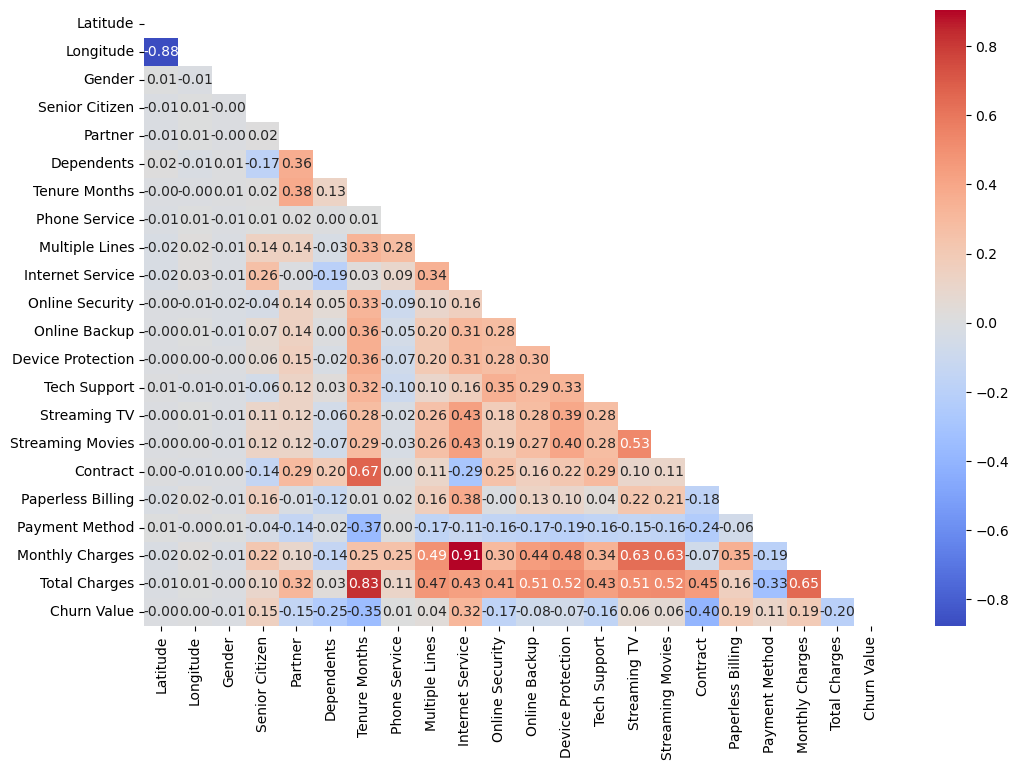

In [20]:
plt.figure(figsize=(12, 8)) # correlation matrix to show correlations between our newly numerical data

sns.heatmap(
    df_visual.corr(),
    mask=np.triu(df_visual.corr()),
    annot=True,           
    fmt='.2f',             
    cmap='coolwarm'           
)

plt.show()

#### Key findings
* less likely to churn if you are with family members (Partners and Dependents)
* more likely to churn if you are old and alone
* more likely to churn if you have internet service (+ other features) might be because you're paying more? or don't need the features you have?
* less likely to churn if you have been a customer for a long time (tenure months)
* less likely to churn if you've spent a lot in total (total charges) but more likely as you spend more each month (monthly charges)

#### Features with the most influence
* Contract
* Tenure Months
* Internet service
* Dependents/Partner/Senior
* Paperless billing
* Monthly charges
* Streaming TV/Movies

# 3. Linreg Model

## 3.1 Feature Engineering

In [21]:
def feature_engineering(df): # feature engineering for relevant features; either dictionary mapping or OHE for features with > 2 unique values
    df = df[feature_cols].copy()
    df['Gender'] = df['Gender'].map({'Female':0, 'Male':1, 0:0, 1:1})
    df['Senior Citizen'] = df['Senior Citizen'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Partner'] = df['Partner'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Dependents'] = df['Dependents'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df['Phone Service'] = df['Phone Service'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df = pd.get_dummies(df, columns = ['Multiple Lines'], drop_first = True, prefix = 'Multiple_Lines', dtype = int)
    df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = True, prefix = 'Internet_Service', dtype = int)
    df = pd.get_dummies(df, columns = ['Online Security'], drop_first = True, prefix = 'Online_Security', dtype = int)
    df = pd.get_dummies(df, columns = ['Online Backup'], drop_first = True, prefix = 'Online_Backup', dtype = int)
    df = pd.get_dummies(df, columns = ['Device Protection'], drop_first = True, prefix = 'Device_Protection', dtype = int)
    df = pd.get_dummies(df, columns = ['Tech Support'], drop_first = True, prefix = 'Tech_Support', dtype = int)
    df = pd.get_dummies(df, columns = ['Streaming TV'], drop_first = True, prefix = 'Streaming_TV', dtype = int)
    df = pd.get_dummies(df, columns = ['Streaming Movies'], drop_first = True, prefix = 'Streaming_Movies', dtype = int)
    df = pd.get_dummies(df, columns = ['Contract'], drop_first = True, prefix = 'Contract', dtype = int)
    df['Paperless Billing'] = df['Paperless Billing'].map({'No':0, 'Yes':1, 0:0, 1:1})
    df = pd.get_dummies(df, columns = ['Payment Method'], drop_first = True, prefix = 'Payment_Method', dtype = int)
        
    return df

df_fe = feature_engineering(df)

In [22]:
df_fe.dtypes # checking that all features are now numerical

Latitude                                  float64
Longitude                                 float64
Gender                                      int64
Senior Citizen                              int64
Partner                                     int64
Dependents                                  int64
Tenure Months                               int64
Phone Service                               int64
Paperless Billing                           int64
Monthly Charges                           float64
Total Charges                             float64
Churn Value                                 int64
Multiple_Lines_No phone service             int32
Multiple_Lines_Yes                          int32
Internet_Service_Fiber optic                int32
Internet_Service_No                         int32
Online_Security_No internet service         int32
Online_Security_Yes                         int32
Online_Backup_No internet service           int32
Online_Backup_Yes                           int32


## 3.2 Feature selection

#### VIF

In [23]:
def calculate_vif(X, thresh = 20):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        
        maxloc = vif.index(max(vif)) # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables]) # finally, we print the variables that are still in our set
    return X.iloc[:, variables] # and return our X cut down to the remaining variables777

In [24]:
VIF_variables = calculate_vif(df_fe[list(df_fe.columns)])

# Error shows 'RuntimeWarning: divide by zero encountered in scalar divide vif = 1. / (1. - r_squared_i)' this is because
# the R^2 for some features is 1 resulting in 1 / 0, this causes the error since VIF is essentially infinite.
# this happens when the variance in the target for a specific feature is fully explainable by a combination of other features
# high levels of multicollinearity

C:\Users\legom\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


dropping 'Internet_Service_No' at index: 15
dropping 'Online_Security_No internet service' at index: 15
dropping 'Online_Backup_No internet service' at index: 16
dropping 'Device_Protection_No internet service' at index: 17
dropping 'Tech_Support_No internet service' at index: 18
dropping 'Streaming_TV_No internet service' at index: 19
dropping 'Phone Service' at index: 7
dropping 'Monthly Charges' at index: 8
dropping 'Longitude' at index: 1
dropping 'Total Charges' at index: 7
Remaining variables:
Index(['Latitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Paperless Billing', 'Churn Value',
       'Multiple_Lines_No phone service', 'Multiple_Lines_Yes',
       'Internet_Service_Fiber optic', 'Online_Security_Yes',
       'Online_Backup_Yes', 'Device_Protection_Yes', 'Tech_Support_Yes',
       'Streaming_TV_Yes', 'Streaming_Movies_No internet service',
       'Streaming_Movies_Yes', 'Contract_One year', 'Contract_Two year',
       'Payment_Method_C

#### Stepwise

> Note: Stepwise is used for linear regression models, we decided to use it for our logistic regression model since logreg shares structural similarities with linreg. So we felt it was still beneficial for predicting features that could contribute towards classification.

In [25]:
def stepwise_selection(X, y, threshold_in = 0.01, threshold_out = 0.05, verbose = True):
    # The function is checking for p-values (whether features are statistically significant) - lower is better
    included = [] # this is going to be the list of features we keep
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = 'float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        # we add the feature with the lowest (best) p-value under the threshold to our 'included' list
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) # specifying the verbose text


        # backward step: removing features if new features added to the list make them statistically insignificant
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        # if the p-value exceeds the upper threshold, the feature will be dropped from the 'included' list
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [26]:
cols = list(df_fe.columns)
cols.remove('Churn Value')
print(cols)
result = stepwise_selection(df_fe[cols], df_fe['Churn Value'])

print('resulting features:')
print(result)

['Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Paperless Billing', 'Monthly Charges', 'Total Charges', 'Multiple_Lines_No phone service', 'Multiple_Lines_Yes', 'Internet_Service_Fiber optic', 'Internet_Service_No', 'Online_Security_No internet service', 'Online_Security_Yes', 'Online_Backup_No internet service', 'Online_Backup_Yes', 'Device_Protection_No internet service', 'Device_Protection_Yes', 'Tech_Support_No internet service', 'Tech_Support_Yes', 'Streaming_TV_No internet service', 'Streaming_TV_Yes', 'Streaming_Movies_No internet service', 'Streaming_Movies_Yes', 'Contract_One year', 'Contract_Two year', 'Payment_Method_Credit card (automatic)', 'Payment_Method_Electronic check', 'Payment_Method_Mailed check']
Add  Tenure Months                  with p-value 7.99906e-205
Add  Internet_Service_Fiber optic   with p-value 4.23886e-186
Add  Dependents                     with p-value 3.08048e-49
Add  Payment_Method_E

## 3.3 Training

Using the features selected by our EDA, VIF and stepwise we created variables for our features and target.

In [27]:
feature_cols = ['Tenure Months', 'Internet_Service_Fiber optic', 'Dependents', 'Payment_Method_Electronic check', 'Contract_One year', 'Device_Protection_No internet service', 'Total Charges', 'Online_Backup_No internet service', 'Online_Security_No internet service', 'Internet_Service_No', 'Streaming_Movies_No internet service', 'Tech_Support_No internet service', 'Streaming_TV_No internet service', 'Online_Security_Yes', 'Paperless Billing', 'Streaming_Movies_Yes', 'Tech_Support_Yes', 'Multiple_Lines_Yes', 'Streaming_TV_Yes', 'Contract_Two year', 'Partner']

X = df_fe[feature_cols]
y = df_fe['Churn Value']

We then split the data into a train and test set, which we both scaled using a scaler fit to the training set.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [29]:
scale_cols = ['Tenure Months', 'Total Charges'] # useful columns which must be scaled
              
scaler = MinMaxScaler()
scaler.fit(X_train[scale_cols]) # scaler is fit on the training data

def scale(df, scaler, scale_cols):
    df = df.copy()
    df[scale_cols] = scaler.transform(df[scale_cols]) # apply the passed scaler to the passed dataframe
    return df

In [30]:
X_train_scaled = scale(X_train, scaler, scale_cols)
X_test_scaled = scale(X_test, scaler, scale_cols)

The logistic regression model was fit to the training features and target. But was balanced due to the imbalance in class samples.

In [31]:
lr = LogisticRegression(max_iter=300, random_state=10, class_weight='balanced') # balanced due to sample imbalance

In [32]:
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=300, random_state=10)

Our model coefficients are as follows:

In [33]:
coefficients = lr.coef_[0]
coeff_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': coefficients
})

coeff_df.sort_values('Coefficient', ascending=False)

,Feature,Coefficient
6,Total Charges,1.300890
1,Internet_Service_Fiber optic,0.545130
3,Payment_Method_Electronic check,0.383253
14,Paperless Billing,0.359366
20,Partner,0.240595
17,Multiple_Lines_Yes,0.219106
15,Streaming_Movies_Yes,0.218810
18,Streaming_TV_Yes,0.217792
12,Streaming_TV_No internet service,-0.132549
11,Tech_Support_No internet service,-0.132549


This indicates that our model believes the following:
* The longer a customer has been with us, the less likely they are to churn
* The longer the contract, the less likely a customer is to churn
* The larger the family makeup of a customer, the less likely they are to churn
* Likelihood of churning increases as total charges increases
    * This is likely because it's calculated with Price
    * And given all other features are constant between two observations, the customer paying more would be more likely to churn
* Customers using Fiber Optic are more likely to churn. This likely ties in with reasons like 'Competitors provide faster speeds'


## 3.4 Predictions

Predictions are made on both the train and test sets.

In [34]:
df_prediction = X_train_scaled.copy()
df_prediction[['prob_not_churn', 'prob_churn']] = lr.predict_proba(X_train_scaled)
df_prediction['Churn Value'] = y_train

df_test_prediction = X_test_scaled.copy()
df_test_prediction[['prob_not_churn', 'prob_churn']] = lr.predict_proba(X_test_scaled)
df_test_prediction['Churn Value'] = y_test

Those probabilities are rounded to either 0 or 1, with a threshold of 0.5.

In [35]:
df_prediction['y_pred'] = np.where(df_prediction['prob_churn']>0.5, 1, 0)
df_test_prediction['y_pred'] = np.where(df_test_prediction['prob_churn']>0.5, 1, 0)

## 3.5 Results

The results of our model predictions on both the test and train set are as follows:

In [36]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(metrics.confusion_matrix(actual, predicted), "\n")
    print(f'The accuracy of your model is: {metrics.accuracy_score(actual, predicted)}')
    print(f'The recall of your model is: {metrics.recall_score(actual, predicted)}')
    print(f'The precision of your model is: {metrics.precision_score(actual, predicted)}')
    print(f'The F1-score of your model is: {metrics.f1_score(actual, predicted)}')

In [37]:
get_results(y_train, df_prediction['y_pred'])

The confusion matrix for your predictions is:
[[3082 1083]
 [ 276 1193]] 

The accuracy of your model is: 0.7587859424920128
The recall of your model is: 0.8121170864533697
The precision of your model is: 0.5241652021089631
The F1-score of your model is: 0.6371161548731642


In [38]:
get_results(y_test, df_test_prediction['y_pred'])

The confusion matrix for your predictions is:
[[725 284]
 [ 81 319]] 

The accuracy of your model is: 0.7409510290986515
The recall of your model is: 0.7975
The precision of your model is: 0.5290215588723052
The F1-score of your model is: 0.6360917248255235


# 4. Decision Tree

# 5. Demographics

#### Where 'Churn Value' = 1, what do those customers 'look like'?
* Gender
* Age
* Family Makeup

In [40]:
df[df['Churn Value']==1].pivot_table(
    index = 'Gender', 
    columns = ['Senior Citizen','Partner', 'Dependents'], 
    aggfunc = {'Count':'count'}
)

Count                               
Senior Citizen    No               Yes             
Partner           No      Yes       No      Yes    
Dependents        No Yes   No Yes   No Yes   No Yes
Gender                                             
Female           439  22  209  29  155   4   76   5
Male             438  23  213  20  118   1  115   2

Churn percentage across both `Genders` was very equal:

In [103]:
pd.crosstab(df['Gender'], df['Churn Value'], normalize='index').round(4)*100

Churn Value,0,1
Gender,,
Female,73.08,26.92
Male,73.84,26.16


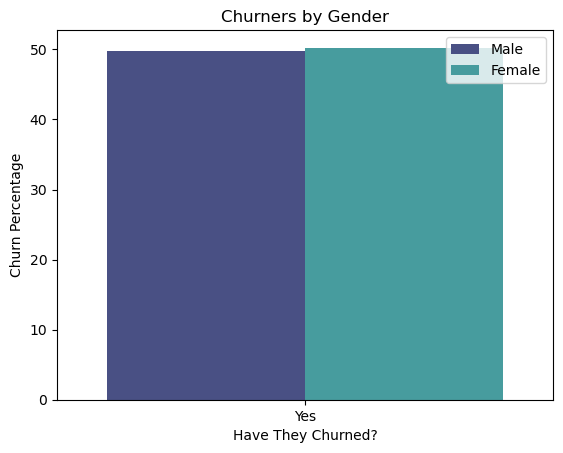

In [108]:
sns.countplot(df[df['Churn Value']==1], x='Churn Label', hue='Gender', stat='percent', palette='mako')
plt.title(label='Churners by Gender')
plt.xlabel(xlabel='Have They Churned?')
plt.ylabel(ylabel='Churn Percentage')
plt.legend(loc='upper right')
plt.show()

Churn percentage is much higher in `Senior Citizens`:

In [104]:
pd.crosstab(df['Senior Citizen'], df['Churn Value'], normalize='index').round(4)*100

Churn Value,0,1
Senior Citizen,,
No,76.39,23.61
Yes,58.32,41.68


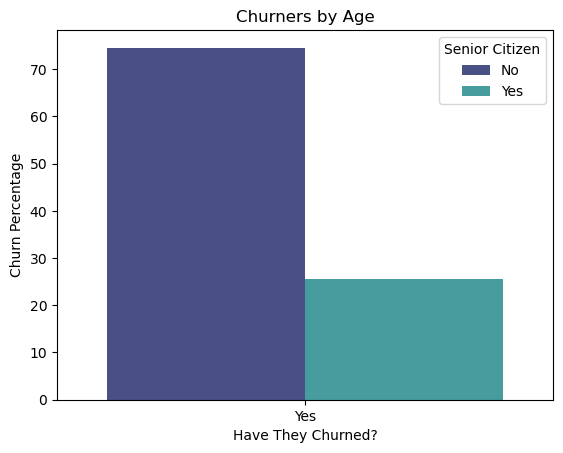

In [112]:
sns.countplot(df[df['Churn Value']==1], x='Churn Label', hue='Senior Citizen', stat='percent', palette='mako')
plt.title(label='Churners by Age')
plt.xlabel(xlabel='Have They Churned?')
plt.ylabel(ylabel='Churn Percentage')
plt.legend(title = 'Senior Citizen', loc='upper right')
plt.show()

Churn percentage is much higher in people without `Dependents`:

In [105]:
pd.crosstab(df['Dependents'], df['Churn Value'], normalize='index').round(4)*100

Churn Value,0,1
Dependents,,
No,67.45,32.55
Yes,93.48,6.52


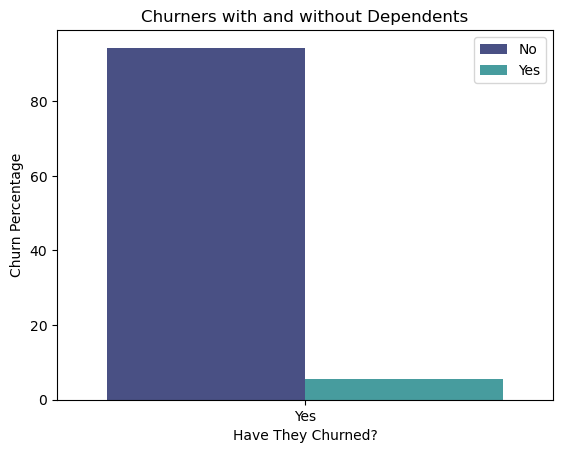

In [111]:
sns.countplot(df[df['Churn Value']==1], x='Churn Label', hue='Dependents', stat='percent', palette='mako')
plt.title(label='Churners with and without Dependents')
plt.xlabel(xlabel='Have They Churned?')
plt.ylabel(ylabel='Churn Percentage')
plt.legend(loc='upper right')
plt.show()

Churn percentage is higher in those without `Partners`:

In [106]:
pd.crosstab(df['Partner'], df['Churn Value'], normalize='index').round(4)*100

Churn Value,0,1
Partner,,
No,67.04,32.96
Yes,80.34,19.66


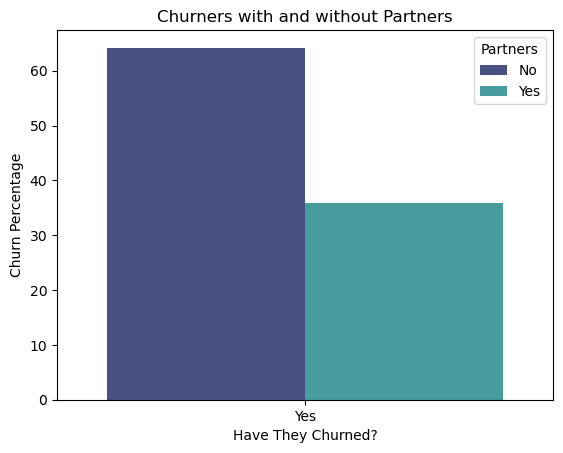

In [113]:
sns.countplot(df[df['Churn Value']==1], x='Churn Label', hue='Partner', stat='percent', palette='mako')
plt.title(label='Churners with and without Partners')
plt.xlabel(xlabel='Have They Churned?')
plt.ylabel(ylabel='Churn Percentage')
plt.legend(title='Partners', loc='upper right')
plt.show()

# 6. Why are people churning?

This compares the percentage of people that have a feature, from the set of churners vs non-churners. Due to imbalances in the data we need to use aggregates that aren't impacted by the imbalance. (e.g. mean)

In [45]:
def compare_churn_features(df, target='Churn Value'):
    churners = df[df[target] == 1] # create the set of churners
    non_churners = df[df[target] == 0] # create the set of non-churners
    
    feature_cols = df.columns.drop(target) 
    
    rows = []

    for col in feature_cols: # for each feature and churn vs non-churn, calculate the mean and difference in means
        churn_mean = churners[col].mean()
        non_churn_mean = non_churners[col].mean()
        diff = non_churn_mean - churn_mean

        rows.append({
            'Feature': col,
            'Mean (Churners)': round(churn_mean, 2),
            'Mean (Non-Churners)': round(non_churn_mean, 2),
            'Difference': round(diff, 2)
        })

    table = pd.DataFrame(rows) # convert to a DF
    table.sort_values(by='Difference', ascending=False, inplace=True) # sort by largest differences
    return table

In [46]:
compare_churn_features(df_visual)

,Feature,Mean (Churners),Mean (Non-Churners),Difference
20,Total Charges,1531.80,2549.91,1018.12
6,Tenure Months,17.98,37.57,19.59
16,Contract,0.14,0.89,0.75
5,Dependents,0.06,0.29,0.24
10,Online Security,0.16,0.33,0.18
4,Partner,0.36,0.53,0.17
13,Tech Support,0.17,0.34,0.17
11,Online Backup,0.28,0.37,0.09
12,Device Protection,0.29,0.36,0.07
0,Latitude,36.27,36.29,0.02


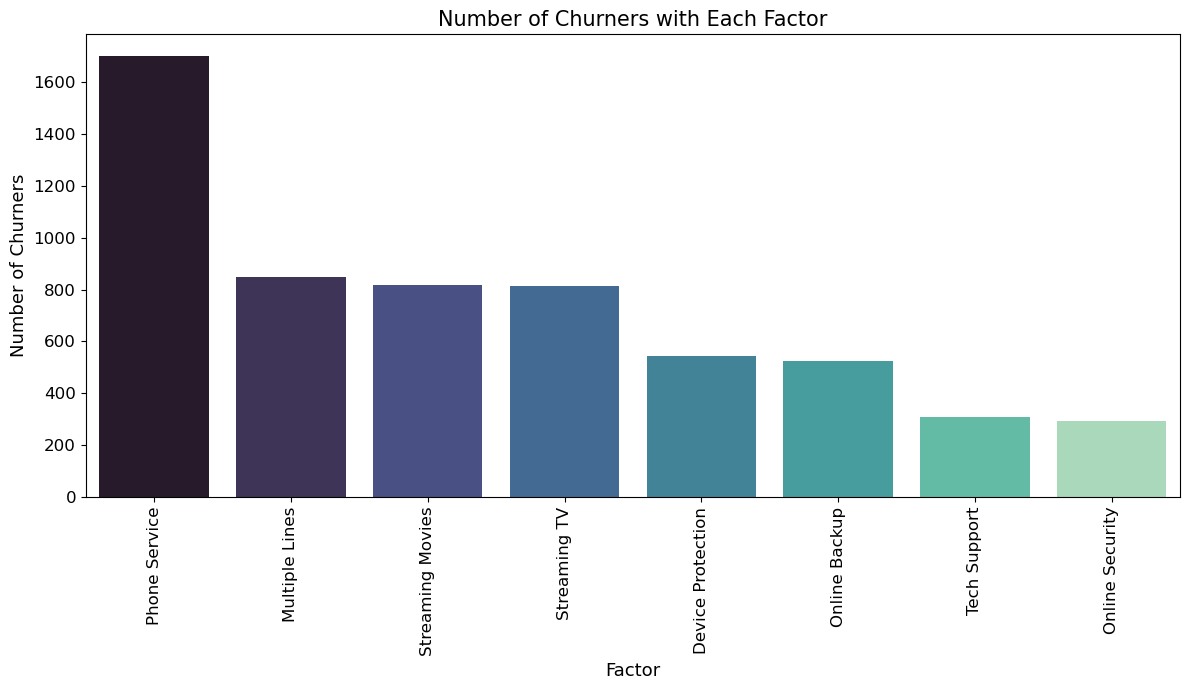

In [115]:
features = [
    'Phone Service', 'Multiple Lines', 'Online Security',
    'Online Backup', 'Device Protection', 'Tech Support',
    'Streaming TV', 'Streaming Movies'
]

feature_sums = df_visual[df_visual['Churn Value'] == 1][features].sum().sort_values(ascending = False)

plt.figure(figsize=(12,7))

barplot = sns.barplot(
    x=feature_sums.index,
    y=feature_sums.values,
    hue=feature_sums.index,
    palette='mako'
)

plt.title('Number of Churners with Each Factor', fontsize=15)
plt.ylabel('Number of Churners', fontsize=13)
plt.xlabel('Factor', fontsize=13)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Another important consideration are the reasons churners have provided for why they churned. The largest ones being:
* Poor suppport
* Better competitors

In [47]:
df['Churn Reason'].value_counts()

Churn Reason
Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: c

Interestingly, of the 146 customers that stated 'Attitude of support person' as their reason for leaving, only 28 had paid for Tech Support. Perhaps this indicates too severe of a difference between paid and free support.

In [48]:
df[df['Churn Reason']=='Attitude of support person'].value_counts('Tech Support') # This is potentially an interesting find. Most people that dislike the support don't have tech support.

Tech Support
No                     146
Yes                     28
No internet service     18
Name: count, dtype: int64

**From the two tables below we noticed the following:**
* Customers with fiber optic are most likely to churn
    * Perhaps due to higher prices or poor service
    * Likely related to this churn reason 'Competitor offered higher download speeds'
* DSL customers are relatively more likely to stay
* Customers with No internet service are least likely to churn

In [75]:
df[df['Churn Value']==1]['Internet Service'].value_counts(normalize=True)

Internet Service
Fiber optic    0.693954
DSL            0.245586
No             0.060460
Name: proportion, dtype: float64

In [76]:
df[df['Churn Value']==0]['Internet Service'].value_counts(normalize=True)

Internet Service
DSL            0.379204
Fiber optic    0.347700
No             0.273096
Name: proportion, dtype: float64

# 7. Top 500 most likely to churn

The top 500 most likely to churn customers are the customers with the highest 'prob_churn' value predicted by the model.

We scale the full dataset using the same scaler from before, make our predictions and then round those predictions based on a threshold of 0.5.

However, we are only interested in customers who have not yet churned ['Churn Value' == 0].

In [68]:
df_fe_scaled = scale(df_fe, scaler, scale_cols) # scaling the feature engineered dataframe from before the split

In [81]:
full_prediction = pd.read_csv('data.csv') # creating a new dataframe of the original data (more readable for Swan consulting)
full_prediction[['prob_not_churn', 'prob_churn']] = lr.predict_proba(df_fe_scaled[feature_cols]) # attach the predictions for the scaled df data to the original data
full_prediction['y_pred'] = np.where(full_prediction['prob_churn']>0.5, 1, 0) # round those predictions as a new column
full_prediction['prob_churn_rounded'] = (full_prediction['prob_churn']*100).round(2)

In [82]:
full_prediction[full_prediction['Churn Value'] == 0].sort_values('prob_churn', ascending = False).head(500)[['CustomerID']].to_csv('top_500.csv', index=False) # this saves the top 500 most likely to churn to a new csv file

# 8. Remaining customer churn probability

For the probability of all customers that haven't churned yet, we simply check ['Churn Value'] == 0] without a LIMIT on the number of observations.

In [85]:
full_prediction[full_prediction['Churn Value'] == 0].sort_values('prob_churn', ascending = False).rename(columns={'prob_churn_rounded': 'Probability'})[['CustomerID', 'Probability']].to_csv('remaining_customers.csv', index=False) # this saves all customers that haven't churned to a new csv file